In [2]:
import sys
sys.path.append('/eos/user/f/fcampono/.local/lib/python3.11/site-packages')  

import cv2
import time
import os
import pandas as pd
import numpy as np
import awkward as ak
import uproot
import vector
import fastjet
import logging
from matplotlib import pyplot as plt
from energyflow.utils import (center_ptyphims, reflect_ptyphims, rotate_ptyphims, pixelate)
import json

# Registrazione dei vettori
vector.register_awkward()

In [2]:
# Funzione per leggere il file ROOT
def read_file(
        filepath,
        max_num_particles=128,
        particle_features=['part_pt', 'part_eta', 'part_phi', 'part_energy'],
        jet_features=['jet_pt', 'jet_eta', 'jet_phi', 'jet_energy'],
        labels=['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q',
                'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']):

    def _pad(a, maxlen, value=0, dtype='float32'):
        if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
            return a
        elif isinstance(a, ak.Array):
            if a.ndim == 1:
                a = ak.unflatten(a, 1)
            a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
            return ak.values_astype(a, dtype)
        else:
            x = (np.ones((len(a), maxlen)) * value).astype(dtype)
            for idx, s in enumerate(a):
                if not len(s):
                    continue
                trunc = s[:maxlen].astype(dtype)
                x[idx, :len(trunc)] = trunc
            return x

    table = uproot.open(filepath)['tree'].arrays()

    p4 = vector.zip({'px': table['part_px'],
                     'py': table['part_py'],
                     'pz': table['part_pz'],
                     'energy': table['part_energy']})
    table['part_pt'] = p4.pt
    table['part_eta'] = p4.eta
    table['part_phi'] = p4.phi

    x_particles = np.stack([ak.to_numpy(_pad(table[n], maxlen=max_num_particles)) for n in particle_features], axis=1)
    x_jets = np.stack([ak.to_numpy(table[n]).astype('float32') for n in jet_features], axis=1)
    y = np.stack([ak.to_numpy(table[n]).astype('int') for n in labels], axis=1)

    return x_particles, x_jets, y

# Funzione per cambiare il vettore
def changeVector(pt, eta, phi):
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    e = np.sqrt(pt**2 + pz**2)
    return e, px, py, pz

# Funzione per ottenere i percorsi dei file
#def get_filepaths(base_dir, num_parts=10, num_files_per_part=10):
#    filepaths_list = []
#    for i in range(num_parts):  # 0 to 9
#        part_dir = os.path.join(base_dir, f"JetClass_Pythia_train_100M_part{i}")
#        for j in range(num_files_per_part):  # 000 to 009, 010 to 019, etc.
#            filename = f"HToBB_{i*10 + j:03d}.root"  # Filename of the root file
#            filepath = os.path.join(part_dir, filename)
#            filepaths_list.append(filepath)  # Save the file path
#return filepaths_list

def get_filepaths(base_dir, num_parts=10, num_files_per_part=10, exclude_files=None):
    if exclude_files is None:
        exclude_files = []  # Lista vuota se non viene passata una lista di esclusione
    
    filepaths_list = []
    for i in range(num_parts):  # 0 to 9
        part_dir = os.path.join(base_dir, f"JetClass_Pythia_train_100M_part{i}")
        for j in range(num_files_per_part):  # 000 to 009, 010 to 019, etc.
            filename = f"TTBar_{i*10 + j:03d}.root"  # Filename of the root file
            
            # Escludi il file se il numero è nella lista di esclusione
            if f"{i*10 + j:03d}" not in exclude_files:
                filepath = os.path.join(part_dir, filename)
                filepaths_list.append(filepath)  # Aggiungi il percorso del file
    
    return filepaths_list

In [3]:
###### Directory base dei file ROOT
base_dir = "/eos/user/f/fcampono/PRIN_JetImgs/Dataset/Dataset_root/"

# file esclusi dalla generazione delle prime 10 k immagini a 100 jets
exclude_files = [f"{i:03}" for i in range(57)]

#exclude_files = []
# Ottieni la lista dei file escludendo quelli indicati
list_dir = get_filepaths(base_dir, exclude_files=exclude_files)

# Ottieni la lista dei file
#list_dir = get_filepaths(base_dir)

# Parametri principali
number_jets = 100000
max_images = 517
batch_step = 2500    # num di jet considerati per immagine
images_generated = 0
images_counter = 0

# Itera sui file ROOT
for index_root in range(len(list_dir)):  # Itera sulla lista dei file
    if images_generated == max_images:
        print("Numero massimo di immagini generato. Interruzione del processo.")
        break

    file_path = list_dir[index_root]
    print(f"Inizio elaborazione file {index_root + 1}/{len(list_dir)}: {file_path}")
    
    try:
        # Legge il file ROOT
        x_particles, x_jet, y = read_file(file_path)
        
        # Stampa il numero di righe
        num_righe = len(x_particles)
        print(f"Numero di righe trovate nel file {file_path}: {num_righe}")
        
        # Inizia l'elaborazione dei dati
        njets = number_jets  # Numero di eventi da processare
        jetdef1 = fastjet.JetDefinition(fastjet.antikt_algorithm, 1)

        rows = []  # Lista per raccogliere le righe del DataFrame
        
        # Ciclo sugli eventi e sui jet
        for count, (part, jet) in enumerate(zip(x_particles[:njets], x_jet[:njets])):
            pt_jet = jet[0]
            eta_jet = jet[1]
            phi_jet = jet[2]

            partons1 = []
            for i in range(part.shape[1]):
                pt_part = part[0][i]
                eta_part = part[1][i]
                phi_part = part[2][i]
                
                if pt_part > 0 and pt_part < 30:
                    e, px, py, pz = changeVector(pt_part, eta_part, phi_part)
                    partons1.append(fastjet.PseudoJet(float(px), float(py), float(pz), float(e)))
            
            cs1 = fastjet.ClusterSequence(partons1, jetdef1)
            cluster1 = cs1.inclusive_jets()
            cluster1_sorted = sorted(cluster1, key=lambda j: j.pt(), reverse=True)
            
            for idx, subjet in enumerate(cluster1_sorted):
                pt_subjet = subjet.pt()
                eta_subjet = subjet.eta()
                phi_subjet = subjet.phi()
                
                constituents = subjet.constituents()
                constituents_data = []
                for constituent in constituents:
                    constituents_data.extend([constituent.pt(), constituent.eta(), constituent.phi()])
                    
                row = [count] + [idx] + [pt_subjet, eta_subjet, phi_subjet] + constituents_data
                rows.append(row)

        # Preparazione del DataFrame
        max_constituents = max(len(row) for row in rows)
        for row in rows:
            while len(row) < max_constituents:
                row.append(0.000000)

        df = pd.DataFrame(rows).fillna(0.0)
        df_new = df.iloc[:, 5:]
        columns_res = df_new.shape[1] // 3
        rown = df_new.shape[0]
        
        max_valid_rows = (rown // batch_step) * batch_step

        for i in range(0, max_valid_rows, batch_step):
            if images_generated >= max_images:
                break

            event_data = df_new.iloc[i:i+batch_step].values.reshape(-1, columns_res, 3)
            
            images = [pixelate(event, 
                               npix=200, 
                               img_width=0.3, 
                               nb_chan=1, 
                               norm=False, 
                               charged_counts_only=False) for event in event_data]
            
            images = np.array(images).reshape(len(images), 200, 200)
            image_sum = np.sum(images, axis=0)
            image_log = np.log1p(image_sum)
            img_n = cv2.normalize(src=image_log, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            
            plt.contourf(img_n, cmap='gray', levels=list(range(0, int(img_n.max() + 10), 20)))
            #plt.colorbar()
            plt.axis('off')

            output_path = f"/eos/user/f/fcampono/PRIN_JetImgs/Jets_patch_noised/Noise_background/TTBar_noise_2500_fileroot_{index_root + 57:03d}_id_{images_counter + 2484:05d}.jpg"
            plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
            plt.close()

            images_counter += 1
            images_generated += 1
    
    except Exception as e:
        print(f"Errore durante l'elaborazione del file {file_path}: {e}")
        continue  # Passa al file successivo 




Inizio elaborazione file 1/43: /eos/user/f/fcampono/PRIN_JetImgs/Dataset/Dataset_root/JetClass_Pythia_train_100M_part5/TTBar_057.root
Numero di righe trovate nel file /eos/user/f/fcampono/PRIN_JetImgs/Dataset/Dataset_root/JetClass_Pythia_train_100M_part5/TTBar_057.root: 100000
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. C

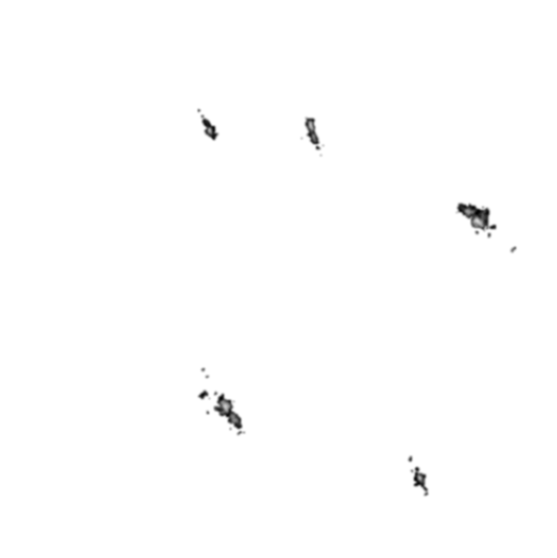

In [6]:
# questa conf sembrerebbe andare per i 25 jet/blob

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Percorsi delle immagini

# Percorsi delle immagini
path_jet = "/eos/user/f/fcampono/PRIN_JetImgs/Jets_patch/Sim_patch_25/jet_25_classe_1/image_1_25_jet_0033.jpg"
path_noise = "/eos/user/f/fcampono/PRIN_JetImgs/Jets_patch_noised/Noise_background/TTBar_noise_2500_fileroot_000_id_00016.jpg"

# Dimensione comune
target_size = (512, 512)

# Carica e ridimensiona entrambe le immagini in scala di grigi
img_jet = Image.open(path_jet).convert('L').resize(target_size)
img_noise = Image.open(path_noise).convert('L').resize(target_size)

# Converti in array numpy
img_jet = np.array(img_jet) 
#img_jet = cv2.GaussianBlur(img_jet, (7, 7), 0)  # Applica blur gaussiano

img_noise = np.array(img_noise)

brightness_offset = 6000
img_noise = np.clip(img_noise+brightness_offset, 0, 255).astype(np.uint8)
#img_noise[(img_noise < 80) | (img_noise > 210)] = 0
#img_noise[img_noise > 1] = 255

mask = img_jet < 100

# Combina le due immagini: mantieni jet dove presente, altrimenti metti rumore
combined = np.where(mask, img_noise, img_jet)

# blur gaussiano
combined = cv2.GaussianBlur(combined, (5, 5), 0)
#combined =  np.clip(combined + brightness_offset, 0, 255).astype(np.uint8)


# Mostra o salva l'immagine risultante
plt.figure(figsize=(10,10))

plt.imshow(combined, cmap='gray')
#plt.colorbar()
plt.axis('off')
plt.show()